# Ensemble de los Top 5 Mejores Modelos (V2) - Conservador
Combina las predicciones de los 5 mejores modelos mediante votación mayoritaria.

**TOP 5 Modelos (basados en F1 Score en validación):**
1. **F2LLM-4B Tweet** - F1: 0.8532
2. **F2LLM-4B Text Clean** - F1: 0.8317
3. **KaLM Tweet** - F1: 0.8254
4. **Ministral 3B** - F1: 0.8073
5. **LogisticRegression (TF-IDF)** - F1: 0.7251

**Nota:** Se usa solo UN modelo KaLM (Tweet) porque ambos (Tweet y Text Clean) comparten el mismo archivo de validación.
Se excluye 3Ministral8B_LoRA por su pésimo rendimiento (F1: 0.0847).

In [1]:
import json
import pandas as pd
import os
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Configuración de los Top 5 Modelos

In [2]:
# Configuración de los Top 5 modelos (Versión Conservadora)
top5_models = [
    {
        'name': 'F2LLM-4B_Tweet',
        'f1_score': 0.8532,
        'val_path': '../results_v2/F2LLM-4B/predictions/dev_predictions_temp.json',
        'test_path': '../results_v2/F2LLM-4B/predictions/BeingChillingWeWillWin_f2llm4B.json'
    },
    {
        'name': 'F2LLM-4B_TextClean',
        'f1_score': 0.8317,
        'val_path': '../results_v2/F2LLM-4B/predictions/dev_predictions_temp_clean.json',
        'test_path': '../results_v2/F2LLM-4B/predictions/BeingChillingWeWillWin_f2llm4Bclean.json'
    },
    {
        'name': 'KaLM_Tweet',
        'f1_score': 0.8254,
        'val_path': '../results_v2/KaLM/predictions/dev_predictions_temp.json',
        'test_path': '../results_v2/KaLM/predictions/BeingChillingWeWillWin_KaLM.json'
    },
    {
        'name': 'Ministral3B',
        'f1_score': 0.8073,
        'val_path': '../results_v2/Ministral3B/predictions/dev_predictions_temp.json',
        'test_path': '../results_v2/Ministral3B/predictions/BeingChillingWeWillWin_Mistral3B.json'
    },
    {
        'name': 'LogReg_TFIDF',
        'f1_score': 0.7251,  # Del CSV: 0.7250996015936255
        'val_path': '../results_v2/clasicos/predictions/val_predictions_temp.json',
        'test_path': '../results_v2/clasicos/BeingChillingWeWillWin_LogisticRegression_TFIDF.json'
    }
]

print("Top 5 Modelos Configurados:")
for i, model in enumerate(top5_models, 1):
    print(f"{i}. {model['name']:<25} F1: {model['f1_score']:.4f}")

Top 5 Modelos Configurados:
1. F2LLM-4B_Tweet            F1: 0.8532
2. F2LLM-4B_TextClean        F1: 0.8317
3. KaLM_Tweet                F1: 0.8254
4. Ministral3B               F1: 0.8073
5. LogReg_TFIDF              F1: 0.7251


## 2. Cargar Gold Standard de Validación

In [3]:
# Cargar gold standard de validación
with open('../preprocessed_data/val_preprocessed_v2.json', 'r', encoding='utf-8') as f:
    val_gold_data = json.load(f)

val_gold_dict = {str(item['id_EXIST']): item['task1'] for item in val_gold_data}
print(f"Validation samples loaded: {len(val_gold_dict)}")

Validation samples loaded: 910


## 3. Cargar Predicciones de los Top 5

In [4]:
def load_predictions_file(file_path):
    """Carga predicciones desde un archivo JSON"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return {str(item['id']): item['value'] for item in data}
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return {}

# Cargar predicciones de validación
val_predictions = {}
for model in top5_models:
    preds = load_predictions_file(model['val_path'])
    if preds:
        val_predictions[model['name']] = preds
        print(f"✓ {model['name']:<25} Val: {len(preds)} samples")
    else:
        print(f"✗ {model['name']:<25} Val: Failed to load")

print(f"\nTotal models loaded for validation: {len(val_predictions)}")

✓ F2LLM-4B_Tweet            Val: 910 samples
✓ F2LLM-4B_TextClean        Val: 910 samples
✓ KaLM_Tweet                Val: 910 samples
✓ Ministral3B               Val: 910 samples
✓ LogReg_TFIDF              Val: 910 samples

Total models loaded for validation: 5


In [5]:
# Cargar predicciones de test
test_predictions = {}
for model in top5_models:
    preds = load_predictions_file(model['test_path'])
    if preds:
        test_predictions[model['name']] = preds
        print(f"✓ {model['name']:<25} Test: {len(preds)} samples")
    else:
        print(f"✗ {model['name']:<25} Test: Failed to load")

print(f"\nTotal models loaded for test: {len(test_predictions)}")

✓ F2LLM-4B_Tweet            Test: 934 samples
✓ F2LLM-4B_TextClean        Test: 934 samples
✓ KaLM_Tweet                Test: 934 samples
✓ Ministral3B               Test: 934 samples
✓ LogReg_TFIDF              Test: 934 samples

Total models loaded for test: 5


## 4. Evaluar Modelos Individuales en Validación

In [6]:
individual_results = []

for name, preds in val_predictions.items():
    common_ids = set(preds.keys()) & set(val_gold_dict.keys())
    
    if len(common_ids) == 0:
        print(f"Warning: No matching IDs for {name}")
        continue
    
    y_true = [val_gold_dict[id_] for id_ in common_ids]
    y_pred = [preds[id_] for id_ in common_ids]
    
    individual_results.append({
        'Model': name,
        'Samples': len(common_ids),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label='YES', zero_division=0),
        'Recall': recall_score(y_true, y_pred, pos_label='YES', zero_division=0),
        'F1': f1_score(y_true, y_pred, pos_label='YES', zero_division=0)
    })

df_individual = pd.DataFrame(individual_results).sort_values('F1', ascending=False)

print("\n" + "="*80)
print("VALIDATION - Individual Model Performance (Top 5)")
print("="*80)
print(df_individual.to_string(index=False))
print("="*80)


VALIDATION - Individual Model Performance (Top 5)
             Model  Samples  Accuracy  Precision   Recall       F1
    F2LLM-4B_Tweet      910  0.859341   0.796574 0.918519 0.853211
F2LLM-4B_TextClean      910  0.834066   0.758130 0.920988 0.831661
       Ministral3B      910  0.814286   0.750000 0.874074 0.807298
        KaLM_Tweet      910  0.814286   0.768182 0.834568 0.800000
      LogReg_TFIDF      910  0.772527   0.727064 0.782716 0.753864


## 5. Ensemble por Votación Mayoritaria

In [7]:
def voting_ensemble(predictions_dict):
    """Aplica votación mayoritaria sobre las predicciones"""
    # Encontrar IDs comunes a todos los modelos
    common_ids = set(list(predictions_dict.values())[0].keys())
    for preds in predictions_dict.values():
        common_ids &= set(preds.keys())
    
    ensemble_preds = {}
    for id_ in common_ids:
        votes = [preds[id_] for preds in predictions_dict.values()]
        # Votación mayoritaria
        ensemble_preds[id_] = Counter(votes).most_common(1)[0][0]
    
    return ensemble_preds

# Generar ensemble para validación
val_ensemble_preds = voting_ensemble(val_predictions)
print(f"Validation ensemble predictions: {len(val_ensemble_preds)} samples")

# Generar ensemble para test
test_ensemble_preds = voting_ensemble(test_predictions)
print(f"Test ensemble predictions: {len(test_ensemble_preds)} samples")

Validation ensemble predictions: 910 samples
Test ensemble predictions: 934 samples


## 6. Evaluar Ensemble en Validación

In [8]:
# Evaluar ensemble
common_ids = set(val_ensemble_preds.keys()) & set(val_gold_dict.keys())

if len(common_ids) > 0:
    y_true = [val_gold_dict[id_] for id_ in common_ids]
    y_pred = [val_ensemble_preds[id_] for id_ in common_ids]
    
    ensemble_metrics = {
        'Model': 'Ensemble_Top5',
        'Samples': len(common_ids),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label='YES', zero_division=0),
        'Recall': recall_score(y_true, y_pred, pos_label='YES', zero_division=0),
        'F1': f1_score(y_true, y_pred, pos_label='YES', zero_division=0)
    }
    
    print("\n" + "="*80)
    print("VALIDATION - Ensemble Performance (Top 5 Models)")
    print("="*80)
    for key, value in ensemble_metrics.items():
        if key != 'Model' and key != 'Samples':
            print(f"{key:<15} {value:.4f}")
        elif key == 'Samples':
            print(f"{key:<15} {value}")
    print("="*80)
else:
    print("No common IDs found for ensemble evaluation")
    ensemble_metrics = None


VALIDATION - Ensemble Performance (Top 5 Models)
Samples         910
Accuracy        0.8593
Precision       0.7966
Recall          0.9185
F1              0.8532


## 7. Comparación: Individual vs Ensemble


COMPARISON: Best Individual vs Ensemble

Best Individual Model: F2LLM-4B_Tweet
  Accuracy:  0.8593
  Precision: 0.7966
  Recall:    0.9185
  F1 Score:  0.8532

Ensemble (Top 5):
  Accuracy:  0.8593
  Precision: 0.7966
  Recall:    0.9185
  F1 Score:  0.8532

Improvement:
  F1 Delta:  +0.0000 (+0.00%)
  Status:    ✗ SIN MEJORA


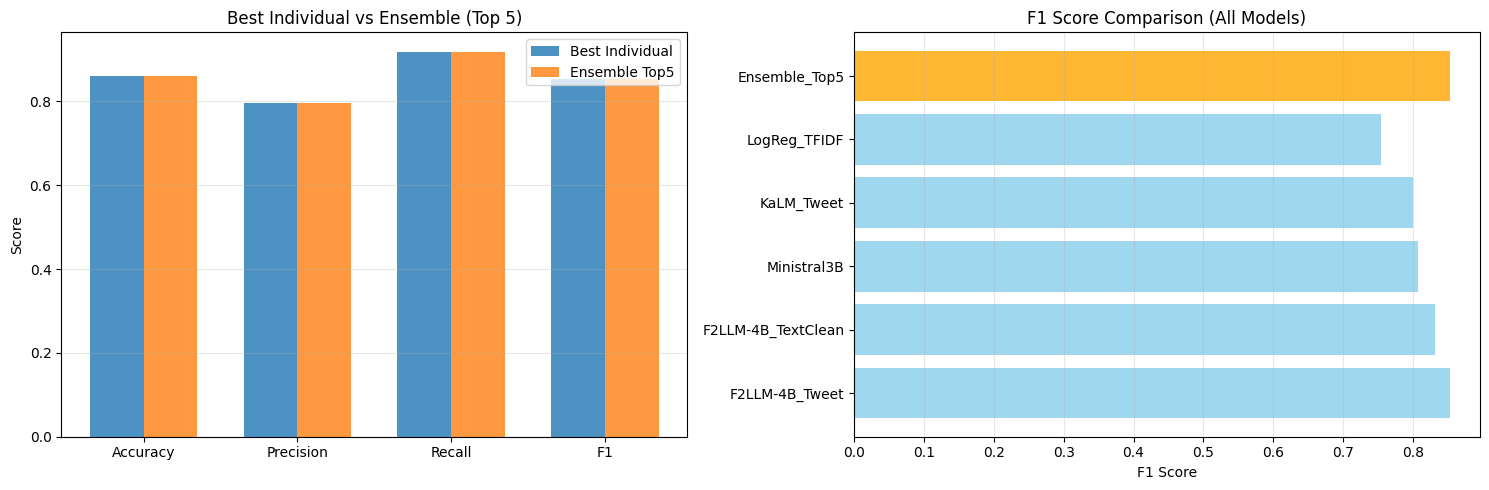

In [9]:
if ensemble_metrics is not None:
    # Comparar resultados
    best_individual = df_individual.iloc[0]
    
    print("\n" + "="*80)
    print("COMPARISON: Best Individual vs Ensemble")
    print("="*80)
    print(f"\nBest Individual Model: {best_individual['Model']}")
    print(f"  Accuracy:  {best_individual['Accuracy']:.4f}")
    print(f"  Precision: {best_individual['Precision']:.4f}")
    print(f"  Recall:    {best_individual['Recall']:.4f}")
    print(f"  F1 Score:  {best_individual['F1']:.4f}")
    
    print(f"\nEnsemble (Top 5):")
    print(f"  Accuracy:  {ensemble_metrics['Accuracy']:.4f}")
    print(f"  Precision: {ensemble_metrics['Precision']:.4f}")
    print(f"  Recall:    {ensemble_metrics['Recall']:.4f}")
    print(f"  F1 Score:  {ensemble_metrics['F1']:.4f}")
    
    # Calcular mejora
    f1_improvement = ensemble_metrics['F1'] - best_individual['F1']
    f1_improvement_pct = (f1_improvement / best_individual['F1']) * 100
    
    print(f"\nImprovement:")
    print(f"  F1 Delta:  {f1_improvement:+.4f} ({f1_improvement_pct:+.2f}%)")
    print(f"  Status:    {'✓ MEJORA' if f1_improvement > 0 else '✗ SIN MEJORA'}")
    print("="*80)
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico 1: Comparación de métricas
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    individual_values = [best_individual[m] for m in metrics]
    ensemble_values = [ensemble_metrics[m] for m in metrics]
    
    x = range(len(metrics))
    width = 0.35
    
    ax1.bar([i - width/2 for i in x], individual_values, width, label='Best Individual', alpha=0.8)
    ax1.bar([i + width/2 for i in x], ensemble_values, width, label='Ensemble Top5', alpha=0.8)
    ax1.set_ylabel('Score')
    ax1.set_title('Best Individual vs Ensemble (Top 5)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Gráfico 2: F1 Scores de todos los modelos
    all_models = df_individual['Model'].tolist() + ['Ensemble_Top5']
    all_f1_scores = df_individual['F1'].tolist() + [ensemble_metrics['F1']]
    colors = ['skyblue'] * len(df_individual) + ['orange']
    
    ax2.barh(all_models, all_f1_scores, color=colors, alpha=0.8)
    ax2.set_xlabel('F1 Score')
    ax2.set_title('F1 Score Comparison (All Models)')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Matriz de Confusión del Ensemble

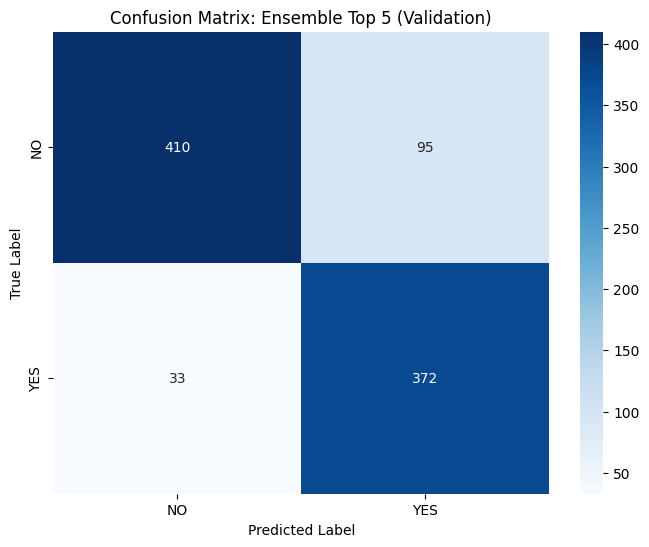


Classification Report - Ensemble Top 5:
              precision    recall  f1-score   support

          NO       0.93      0.81      0.86       505
         YES       0.80      0.92      0.85       405

    accuracy                           0.86       910
   macro avg       0.86      0.87      0.86       910
weighted avg       0.87      0.86      0.86       910



In [10]:
if ensemble_metrics is not None and len(common_ids) > 0:
    cm = confusion_matrix(y_true, y_pred, labels=['NO', 'YES'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
    plt.title('Confusion Matrix: Ensemble Top 5 (Validation)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\nClassification Report - Ensemble Top 5:")
    print(classification_report(y_true, y_pred, labels=['NO', 'YES']))

## 9. Guardar Predicciones del Ensemble

In [11]:
# Crear directorio de salida
os.makedirs('../results_v2/ensemble', exist_ok=True)

# Guardar predicciones de validación
val_output = [{'test_case': 'EXIST2025', 'id': id_, 'value': pred} 
              for id_, pred in val_ensemble_preds.items()]
val_output_path = '../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador_val.json'

with open(val_output_path, 'w', encoding='utf-8') as f:
    json.dump(val_output, f, ensure_ascii=False, indent=2)

print(f"✓ Validation predictions saved: {val_output_path}")
print(f"  Samples: {len(val_ensemble_preds)}")

# Guardar predicciones de test
test_output = [{'test_case': 'EXIST2025', 'id': id_, 'value': pred} 
               for id_, pred in test_ensemble_preds.items()]
test_output_path = '../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador.json'

with open(test_output_path, 'w', encoding='utf-8') as f:
    json.dump(test_output, f, ensure_ascii=False, indent=2)

print(f"✓ Test predictions saved: {test_output_path}")
print(f"  Samples: {len(test_ensemble_preds)}")

✓ Validation predictions saved: ../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador_val.json
  Samples: 910
✓ Test predictions saved: ../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador.json
  Samples: 934


## 10. Resumen Final

In [12]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nTop 5 Models Used:")
for i, model in enumerate(top5_models, 1):
    print(f"  {i}. {model['name']:<30} (Expected F1: {model['f1_score']:.4f})")

if ensemble_metrics is not None:
    print(f"\nEnsemble Performance (Validation):")
    print(f"  Accuracy:  {ensemble_metrics['Accuracy']:.4f}")
    print(f"  Precision: {ensemble_metrics['Precision']:.4f}")
    print(f"  Recall:    {ensemble_metrics['Recall']:.4f}")
    print(f"  F1 Score:  {ensemble_metrics['F1']:.4f}")
    
    if f1_improvement > 0:
        print(f"\n  ✓ Ensemble mejora sobre mejor modelo individual: +{f1_improvement:.4f} ({f1_improvement_pct:+.2f}%)")
    else:
        print(f"\n  ✗ Ensemble NO mejora sobre mejor modelo individual: {f1_improvement:.4f} ({f1_improvement_pct:+.2f}%)")

print(f"\nOutput Files:")
print(f"  Validation: {val_output_path}")
print(f"  Test:       {test_output_path}")
print("="*80)


FINAL SUMMARY

Top 5 Models Used:
  1. F2LLM-4B_Tweet                 (Expected F1: 0.8532)
  2. F2LLM-4B_TextClean             (Expected F1: 0.8317)
  3. KaLM_Tweet                     (Expected F1: 0.8254)
  4. Ministral3B                    (Expected F1: 0.8073)
  5. LogReg_TFIDF                   (Expected F1: 0.7251)

Ensemble Performance (Validation):
  Accuracy:  0.8593
  Precision: 0.7966
  Recall:    0.9185
  F1 Score:  0.8532

  ✗ Ensemble NO mejora sobre mejor modelo individual: 0.0000 (+0.00%)

Output Files:
  Validation: ../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador_val.json
  Test:       ../results_v2/ensemble/BeingChillingWeWillWin_ensemble_top5_conservador.json
